In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 13.2 MB/s eta 0:00:00


In [ ]:
import re
import csv
import numpy as np
import pandas as pd
import nltk
import spacy
import contractions
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, notebook as tqdm_notebook
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


Prepare csv file from the txt file for ease of access

In [ ]:
with open('/content/train_snli.txt') as file:
    data = file.readlines()

with open('data.csv', 'w', newline= '') as csvfile:
    filenames = ['source_txt', 'plagiarism_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)

    writer.writeheader()
    for line in tqdm(data):
        parts = line.strip().split('\t')
        source_txt = parts[0]
        plagiarism_txt = parts[1]
        label = int(parts[2])

        writer.writerow({
            'source_txt' : source_txt,
            'plagiarism_txt' : plagiarism_txt,
            'label' : label
        })

  0%|          | 0/367373 [00:00<?, ?it/s]

Explore dataset to check any abnormalities

In [ ]:
df = pd.read_csv("data.csv")
df.head()

,source_txt,plagiarism_txt,label
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [ ]:
df.shape

(367373, 3)

Remove missing values

In [ ]:
print("Null values count",df.isnull().sum())

Null values count source_txt        0
plagiarism_txt    4
label             0
dtype: int64


In [ ]:
null_rows = df[df.isnull().any(axis=1)]
print(null_rows)

                                       source_txt plagiarism_txt  label
61111             Cannot see picture to describe.            NaN      1
61112             Cannot see picture to describe.            NaN      0
207766  Jumping with purple balls is so much fun!            NaN      0
207767  Jumping with purple balls is so much fun!            NaN      1


In [ ]:
df.dropna(inplace=True)
print("Null values count:",df.isnull().sum())

Null values count: source_txt        0
plagiarism_txt    0
label             0
dtype: int64


Remove duplicates

In [ ]:
print("Duplicates count:", df.duplicated().sum())



Duplicates count: 454


In [ ]:
duplicated_rows = df[df.duplicated(keep=False)]

print(duplicated_rows.head())


                                           source_txt          plagiarism_txt  \
1275      Child in red and blue shirt painting a log.  The child is painting.   
1279      Child in red and blue shirt painting a log.  The child is painting.   
1724       Two small dogs run across the green grass.   Two dogs are outside.   
1726       Two small dogs run across the green grass.   Two dogs are outside.   
1951  A young woman is drawing with a Sharpie marker.     A woman is drawing.   

      label  
1275      1  
1279      1  
1724      1  
1726      1  
1951      1  


In [ ]:
df.drop_duplicates(inplace=True)
print("Duplicates count:",df.duplicated().sum())

Duplicates count: 0


Check data distribution

label
0    183874
1    183041
Name: count, dtype: int64


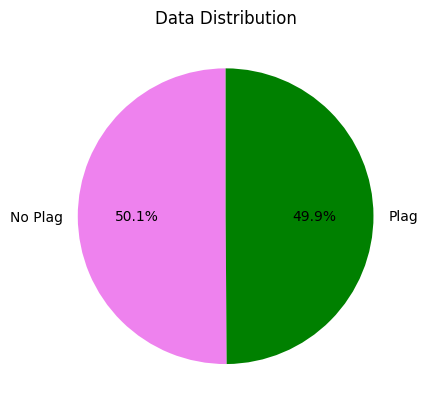

In [ ]:
print(df['label'].value_counts())

df['label'].value_counts().plot.pie(labels=['No Plag', 'Plag'],
                                    colors=['violet','green'],
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    textprops={'color':'black'})
plt.title('Data Distribution')
plt.ylabel('')
plt.show()

The data distribution is not skewed. Hence, no need to perform any data balancing.

**Preprocessing**

Convert to lower case

In [ ]:
df['source_txt'] = df['source_txt'].str.lower()
df['plagiarism_txt'] = df['plagiarism_txt'].str.lower()


Expand shortforms

In [ ]:
df['source_txt'] = df['source_txt'].apply(lambda x: contractions.fix(x) if pd.notnull(x) else x)
df['plagiarism_txt'] = df['plagiarism_txt'].apply(lambda x: contractions.fix(x) if pd.notnull(x) else x)


Remove punctuation marks

In [ ]:
df['source_txt'] = df['source_txt'].str.replace(r'[^\w\s]', '', regex=True)
df['plagiarism_txt'] = df['plagiarism_txt'].str.replace(r'[^\w\s]', '', regex=True)


Remove numbers and special characters

In [ ]:
df['source_txt'] = df['source_txt'].str.replace(r'[^A-Za-z\s]', '', regex=True)
df['plagiarism_txt'] = df['plagiarism_txt'].str.replace(r'[^A-Za-z\s]', '', regex=True)


Remove extra spacings

In [ ]:
df['source_txt'] = df['source_txt'].str.replace(r'\s+', ' ', regex=True).str.strip()
df['plagiarism_txt'] = df['plagiarism_txt'].str.replace(r'\s+', ' ', regex=True).str.strip()


Remove stopwords

In [ ]:
nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['source_txt'] = df['source_txt'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]) if pd.notnull(x) else x)
df['plagiarism_txt'] = df['plagiarism_txt'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]) if pd.notnull(x) else x)


Apply Lemmatization

In [ ]:
tqdm.pandas()

def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df['processed_source_txt'] = df['source_txt'].progress_apply(lambda x: lemmatize(x) if pd.notnull(x) else x)
df['processed_plagiarism_txt'] = df['plagiarism_txt'].progress_apply(lambda x: lemmatize(x) if pd.notnull(x) else x)


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
df.head()

,source_txt,plagiarism_txt,label,processed_source_txt,processed_plagiarism_txt
0,person horse jumps broken airplane,person diner ordering omelette,0,person horse jump break airplane,person diner order omelette
1,person horse jumps broken airplane,person outdoors horse,1,person horse jump break airplane,person outdoors horse
2,children smiling waving camera,children present,1,child smile wave camera,child present
3,children smiling waving camera,kids frowning,0,child smile wave camera,kid frown
4,boy jumping skateboard middle red bridge,boy skates sidewalk,0,boy jump skateboard middle red bridge,boy skate sidewalk


Compute Embeddings using Word2Vec

In [ ]:
def tokenize(text):
    return text.split()

df['processed_plagiarism_txt'] = df['processed_plagiarism_txt'].fillna('')
df['processed_source_txt'] = df['processed_source_txt'].fillna('')

source_sentences = df['processed_source_txt'].apply(lambda x: x.split()).tolist()
plagiarism_sentences = df['processed_plagiarism_txt'].apply(lambda x: x.split()).tolist()

all_sentences = source_sentences + plagiarism_sentences

w2v_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4)

def sentence_to_vec(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

df['source_vec'] = df['processed_source_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))
df['plagiarism_vec'] = df['processed_plagiarism_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))



1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step


In [ ]:
df.head()

,source_txt,plagiarism_txt,label,processed_source_txt,processed_plagiarism_txt,source_vec,plagiarism_vec
0,person horse jumps broken airplane,person diner ordering omelette,0,person horse jump break airplane,person diner order omelette,"[-0.45704693, -0.1896902, -0.032550335, 0.4288...","[0.24938227, 0.6712075, 0.48709977, 0.14496142..."
1,person horse jumps broken airplane,person outdoors horse,1,person horse jump break airplane,person outdoors horse,"[-0.45704693, -0.1896902, -0.032550335, 0.4288...","[0.16390352, -0.44991037, 0.98897177, 1.074600..."
2,children smiling waving camera,children present,1,child smile wave camera,child present,"[-0.5925161, -0.5582761, -0.949546, 1.4925321,...","[0.50024724, 0.7793225, -0.39913756, 0.8936729..."
3,children smiling waving camera,kids frowning,0,child smile wave camera,kid frown,"[-0.5925161, -0.5582761, -0.949546, 1.4925321,...","[-0.22474952, 0.8491028, -0.2458137, 1.2898006..."
4,boy jumping skateboard middle red bridge,boy skates sidewalk,0,boy jump skateboard middle red bridge,boy skate sidewalk,"[-1.0007385, -0.2342198, -0.18485545, -0.37523...","[-0.93835884, -0.04240777, 0.59849364, -0.0859..."


Saving this df as a csv file for later use

In [ ]:
from google.colab import files
df.to_csv('final_data.csv', index=False)
files.download('final_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GRU Model

In [ ]:
X = np.array([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])])
y = np.array(df['label'].values)

# GRU/LSTM expects 3D input: (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
num_gru_layers = 2
gru_units = [64, 32]
dropout_rates = [0.3, 0.2]
dense_units = 64
dense_activation = 'relu'
learning_rate = 0.001
optimizer_choice = 'adam'
batch_size = 32
epochs = 30

In [ ]:
model = Sequential()

for i in range(num_gru_layers):
    # For first layer, specify input_shape, others no need
    if i == 0:
        model.add(GRU(units=gru_units[i], return_sequences=(i < num_gru_layers - 1), input_shape=(X_train.shape[1], X_train.shape[2])))
    else:
        model.add(GRU(units=gru_units[i], return_sequences=(i < num_gru_layers - 1)))
    model.add(Dropout(dropout_rates[i]))

model.add(Dense(units=dense_units, activation=dense_activation))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/30
9173/9173 [==============================] - 55s 6ms/step - loss: 0.4832 - accuracy: 0.7583 - val_loss: 0.4248 - val_accuracy: 0.7992
Epoch 2/30
9173/9173 [==============================] - 43s 5ms/step - loss: 0.4229 - accuracy: 0.8007 - val_loss: 0.3994 - val_accuracy: 0.8164
Epoch 3/30
9173/9173 [==============================] - 45s 5ms/step - loss: 0.4017 - accuracy: 0.8134 - val_loss: 0.3897 - val_accuracy: 0.8198
Epoch 4/30
9173/9173 [==============================] - 45s 5ms/step - loss: 0.3896 - accuracy: 0.8202 - val_loss: 0.3785 - val_accuracy: 0.8279
Epoch 5/30
9173/9173 [==============================] - 46s 5ms/step - loss: 0.3811 - accuracy: 0.8255 - val_loss: 0.3680 - val_accuracy: 0.8311
Epoch 6/30
9173/9173 [==============================] - 45s 5ms/step - loss: 0.3740 - accuracy: 0.8299 - val_loss: 0.3698 - val_accuracy: 0.8318
Epoch 7/30
9173/9173 [==============================] - 45s 5ms/step - loss: 0.3682 - accuracy: 0.8328 - val_loss: 0.3662 - val_ac

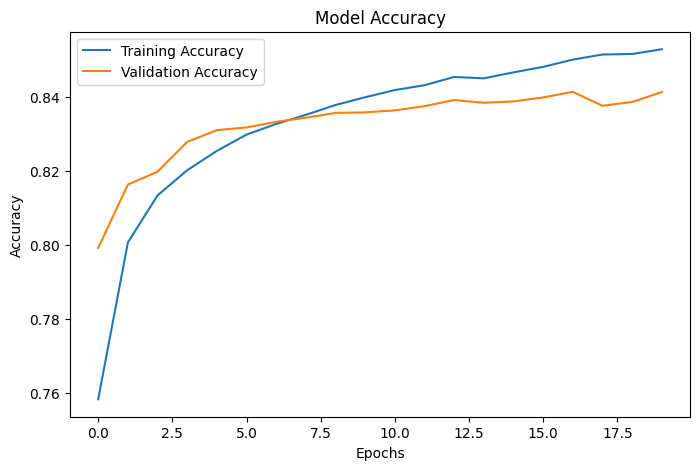

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


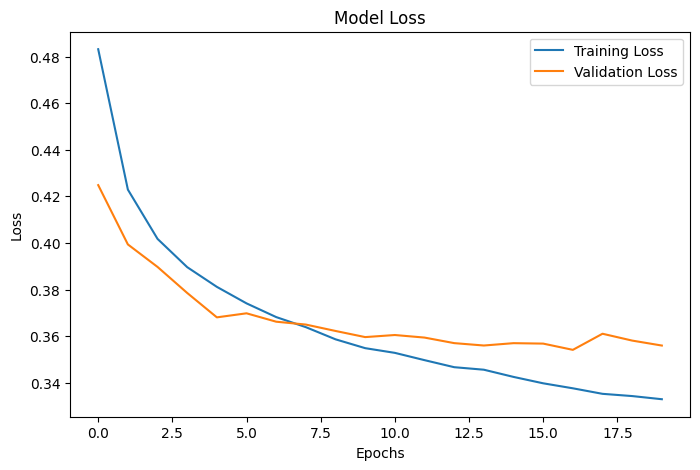

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Testing

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

2294/2294 [==============================] - 6s 2ms/step - loss: 0.3541 - accuracy: 0.8414

Test Accuracy: 84.14%


In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

2294/2294 [==============================] - 7s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84     36869
           1       0.82      0.87      0.84     36514

    accuracy                           0.84     73383
   macro avg       0.84      0.84      0.84     73383
weighted avg       0.84      0.84      0.84     73383



Save models to deploy app

In [ ]:
model.save('best_gru_model.h5')
model.save("best_gru_model.keras")

import pickle
pickle.dump(w2v_model, open('word2vec_model.pkl', 'wb'))